In [1]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.measure import regionprops
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
image_path = '3_R_CC.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Perform resizing and filtering
resized_image = cv2.resize(original_image, (400, 400))  # Adjust the size as needed
filtered_image = cv2.medianBlur(resized_image, 5)  # Adjust the filter size as needed

# Convert the grayscale image to a pseudo-RGB image (3 channels)
filtered_image_rgb = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2RGB)

# Superpixel segmentation using SLIC (Simple Linear Iterative Clustering)
segments = slic(filtered_image_rgb, n_segments=100, compactness=10)

# Resize the original image to match the shape of filtered_image_rgb
resized_original_image = cv2.resize(original_image, (filtered_image_rgb.shape[1], filtered_image_rgb.shape[0]))



In [3]:
features = []
labels = []

# Define center coordinates of the image
center_x, center_y = filtered_image_rgb.shape[1] // 2, filtered_image_rgb.shape[0] // 2

# Define tumor radius
tumor_radius = 24 # Adjust as needed

# Convert the original image to binary using a threshold
_, binary_image = cv2.threshold(original_image, 127, 255, cv2.THRESH_BINARY)

for region in regionprops(binary_image):
    mean_intensity = np.mean(resized_original_image[region.slice])
    features.append(mean_intensity)

    y, x = region.centroid
    distance_to_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    label = 1 if distance_to_center < tumor_radius else 0
    labels.append(label)

features = np.array(features).reshape(-1, 1)
labels = np.array(labels)

C:\Users\kc\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kc\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
# Extract features (mean intensity) from each superpixel
features = []
labels = []

for region in regionprops(segments, intensity_image=resized_original_image):
    mean_intensity = np.mean(region.intensity_image)
    features.append(mean_intensity)
    
    y, x = region.centroid
    distance_to_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    label = 1 if distance_to_center < tumor_radius else 0
    labels.append(label)

features = np.array(features).reshape(-1, 1)
labels = np.array(labels)

In [5]:
# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(features, labels)



KNeighborsClassifier(n_neighbors=3)

In [6]:

# Predict the labels for each superpixel
predictions = knn_classifier.predict(features)

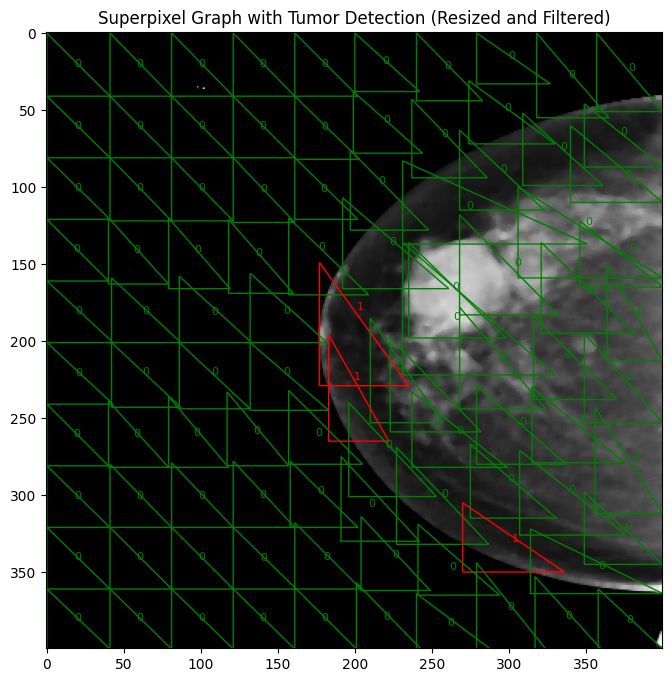

In [7]:
# Visualize the superpixel graph with triangles
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(filtered_image_rgb)

# Mapping between superpixel labels and array indices
label_to_index = {label: idx for idx, label in enumerate(np.unique(segments))}

for region in regionprops(segments):
    y, x = region.centroid
    label_idx = label_to_index[region.label]
    label = predictions[label_idx]
    color = 'r' if label == 1 else 'g'
    
    # Use Polygon to draw a triangle
    triangle = Polygon([(region.bbox[1], region.bbox[0]),
                        (region.bbox[1], region.bbox[2]),
                        (region.bbox[3], region.bbox[2])],
                        fill=False, edgecolor=color, linewidth=1)
    
    ax.add_patch(triangle)
    ax.text(x, y, str(label), color=color, fontsize=8, ha='center', va='center')

plt.title('Superpixel Graph with Tumor Detection (Resized and Filtered)')
plt.show()